## Intro
- This experiments target is to determine adequate tabnet hyperparameters (learning_rate, max_epochs, patience)

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import math
import scipy
import astropy.stats
import sys
import os
sys.path.append(os.getcwd() + "/pytorch_tabnet/")

from sklearn.cluster import DBSCAN

## 0. Experiment Setup

In [4]:
# should an output folder be created to save the experiment data?
save_output = True
save_models = True

In [5]:
# read config file
import toml
config = toml.load("config_tp.toml")

# determine experimental parameter from config
experiment_variable_values = ""
experiment_dict_key = ""
for category_name, category_values in config.items():
    if config["general"]["experiment_variable"] in category_values:
        experiment_variable_values = category_values[config["general"]["experiment_variable"]]
        experiment_dict_key = category_name

patience_values = config["model_param"]["patience"]
epochs_values = config["model_param"]["max_epochs"]
        
# rnd seed to support reproducable results
seed_value =  config["general"]["random_seed"] if config["general"]["random_seed"] else random.randrange(2**32 -1)
random.seed(seed_value)
np.random.seed(seed_value)

# TabNet hyperparameters
experiment_variable = config["general"]["experiment_variable"]
regressor_param = {"optimizer_fn" : torch.optim.Adam,
                   "optimizer_params" : {"lr":0.05},
                   "scheduler_params" : {"step_size": 0.2, "gamma": 0.9},
                   "scheduler_fn" : torch.optim.lr_scheduler.StepLR,
                   "mask_type" : 'entmax',
                   "device_name" : 'cuda', # only working on NVIDIA GPUs
                   "verbose" : 0
                  }

# create experiment folder structure
if save_output or save_models:  
    from datetime import datetime
    
    experiment_name = config["general"]["experiment_name"]
    experiment_folder = f"{datetime.now().strftime('%Y_%m_%d %H-%M-%S')} {experiment_name} " if experiment_name else f"{datetime.now().strftime('%Y_%m_%d %H-%M-%S')} {config['general']['runs']}-runs-{config['general']['experiment_variable']}-{config['model_param']['eval_metric'][0]}"
    
    experiment_path = os.path.join("04_Experiments", experiment_folder)
    os.mkdir(experiment_path)
    
    plots_path = os.path.join(experiment_path, "plots")
    os.mkdir(plots_path)
    
    models_path = os.path.join(experiment_path, "models")
    os.mkdir(models_path)
    
    # save config file
    import shutil
    shutil.copy2("config_tp.toml", experiment_path)
    config_path = os.path.join(experiment_path, "config_tp.toml")
    
    # save random seed
    if not config["general"]["random_seed"]:
        config["general"]["random_seed"] = seed_value
        with open(config_path, "w") as f:
            toml.dump(config, f)
    
    # save model hyperparameters
    with open(os.path.join(experiment_path, 'config_tp.toml'), 'a') as config_file:
        config_file.write("\n#[regressor_param]\n")
        for key, value in regressor_param.items(): 
            config_file.write('#%s = %s\n' % (key, str(value)))
    
    # create output file
    output_path = os.path.join(experiment_path, "output.toml")
    output_file = open(output_path, "w")

output = {}

## 1. Datasets

### 1.0. Use wine dataset
The sklearn wine dataset will be used for all the following experiments.

In [6]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import scale, StandardScaler

wine = load_wine()
X, labels_true = pd.DataFrame(wine.data, columns=wine['feature_names']), wine.target
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=wine['feature_names'])

#### Determine feature distributions
To examine the influence and predictability of outliers, we choose feature of the dataset, that has a distribution including an adequate number of outliers.\
Feature 'alcalinity_of_ash' shows clear outliers in both directions. From here on, this feature will be used to optimize the distribution preservance and prediction of missing values.

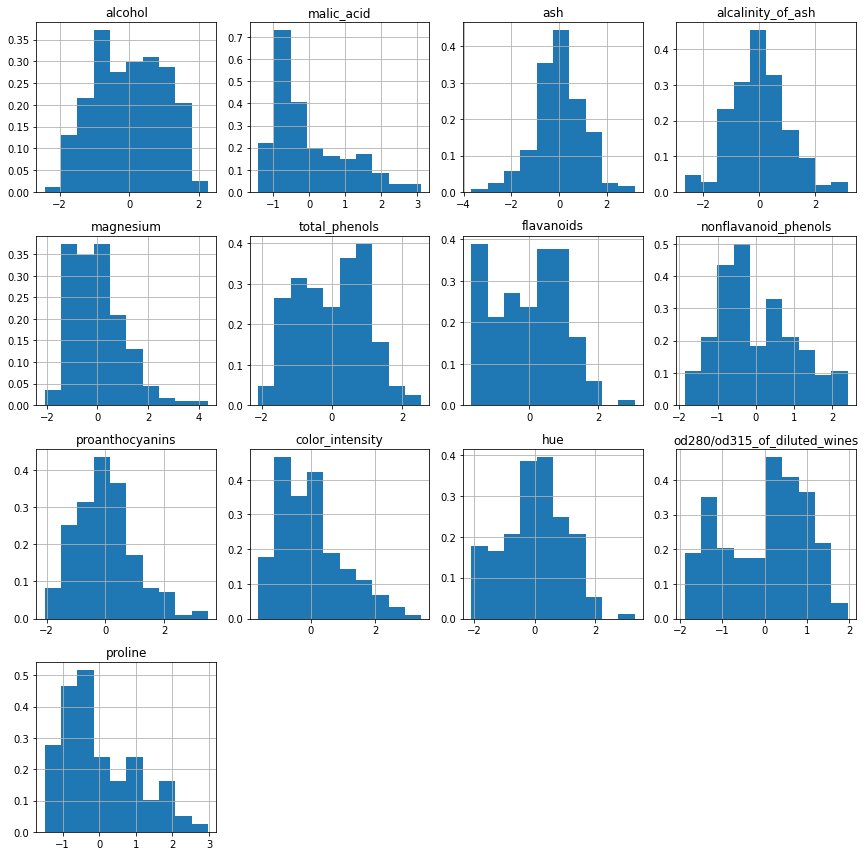

In [7]:
X_scaled.hist(layout=(4,4), figsize=(12,12), density=True)
plt.tight_layout()
plt.show()

In [8]:
experiment_feature = "alcalinity_of_ash"

### 1.1. Create missing data
#### 1.1.1. Create a specified amount of missing values in the given feature columns (for complete datasets).

In [9]:
# create missing values in feature column(s)
mv_config = {feature:mv_ratio for feature,mv_ratio in zip(list(X.columns), config["general"]["missing_percent"])}
X_mv = X.copy()

for f, mv in mv_config.items():
    X_mv[f] = X_mv[f].mask(np.random.random(X.shape[0]) < mv)

features_to_predict = X_mv.columns[X_mv.isnull().any()]

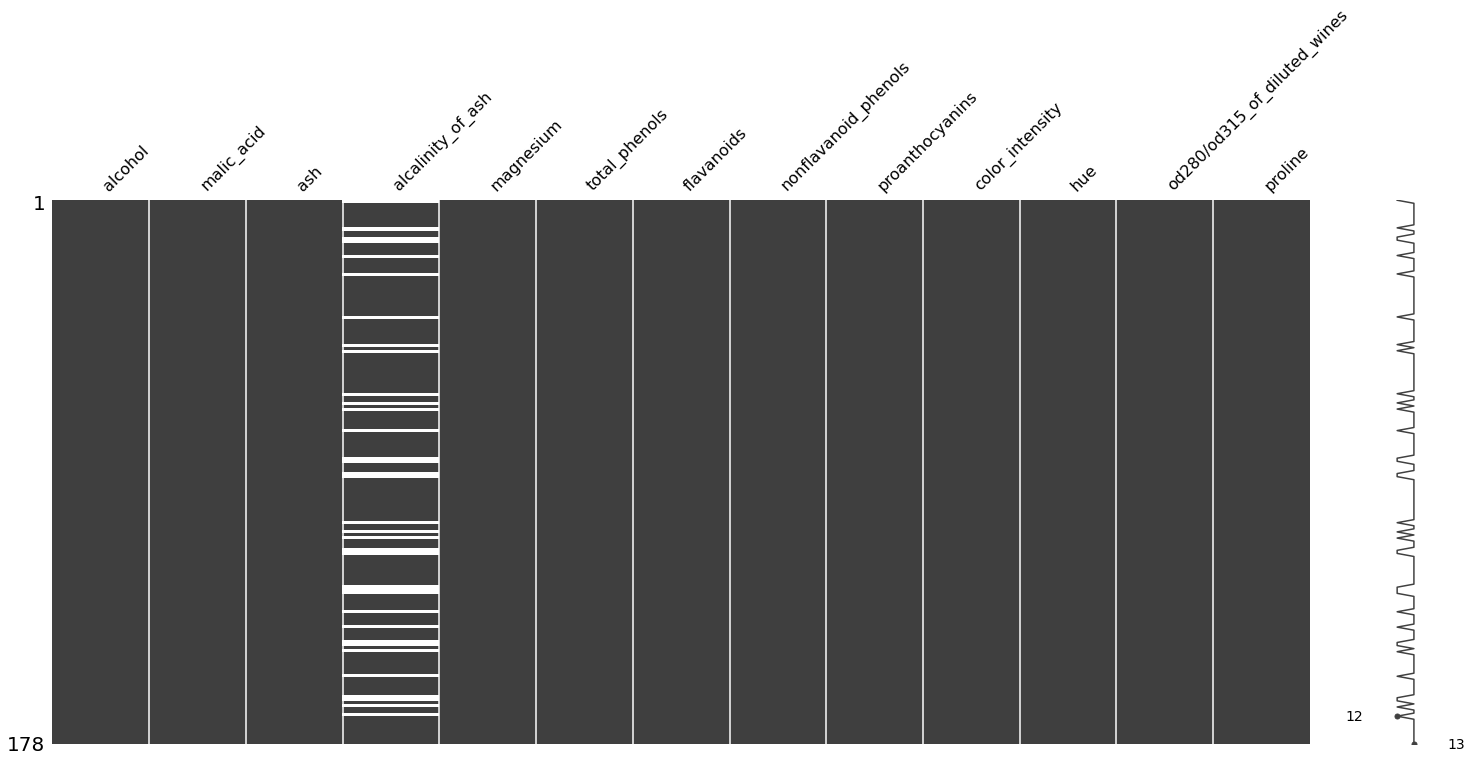

In [10]:
import missingno as msno
%matplotlib inline

# plot missing values
fig = msno.matrix(X_mv)
plt.show()
if save_output:
    #plt.savefig(os.path.join(plots_path, "missing_values.png"), **config["plots"])
    fig_copy = fig.get_figure()
    fig_copy.savefig(os.path.join(plots_path, "missing_values.png"), **config["plots"], bbox_inches = 'tight')

#### 1.1.2. Distribution after removing random values

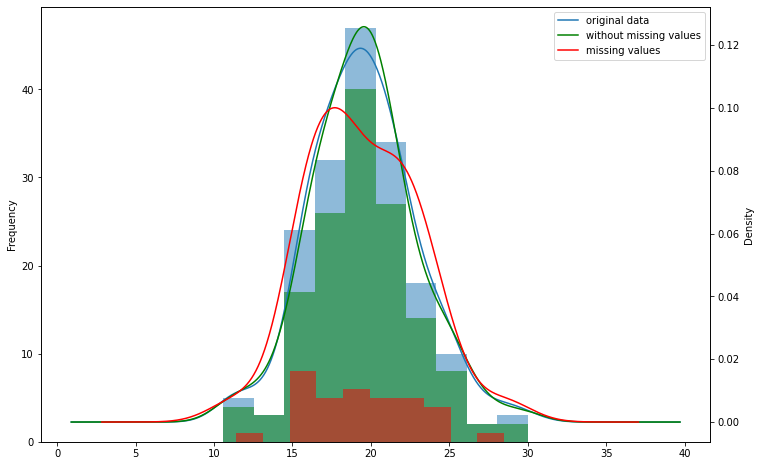

In [11]:
mv = X.copy()[X_mv[experiment_feature].isna()]

fig, ax = plt.subplots(figsize=(12,8))
X[experiment_feature].plot.hist(ax=ax, alpha=0.5)
X_mv[experiment_feature].plot.hist(ax=ax, alpha=0.5, color='green')
mv[experiment_feature].plot.hist(ax=ax, alpha=0.5, color='red')

ax2 = ax.twinx()
X[experiment_feature].plot.kde(ax=ax2)
X_mv[experiment_feature].plot.kde(ax=ax2, color='green')
mv[experiment_feature].plot.kde(ax=ax2, color='red')

plt.legend(['original data', 'without missing values', 'missing values'])

plt.show()

#### 1.1.3. Kurtosis
If the data is sufficiently close to a normal distribution, the Kurtosis measure could be used to compare the tailedness of the data before and after predictions. This does, however not apply for the given feature.

In [12]:
scipy.stats.kurtosistest(X_mv[X_mv[experiment_feature].notna()][experiment_feature])

KurtosistestResult(statistic=1.462411942098053, pvalue=0.1436283588790355)

#### 1.1.4. Inter Quantile Range to determine number of outliers
Using a custom definition for outliers based on the top and bottom x% of values (see config)

In [13]:
def n_outliers(data, quantiles):
    Q1 = np.percentile(data , quantiles[0] * 100)
    Q2 = np.percentile(data , quantiles[1] * 100)
    return data[(data < Q1) | (data > Q2)].shape[0]

In [14]:
output["n_outliers"] = {}
output["n_outliers"]["X"] = {}
output["n_outliers"]["X_mv"] = {}
for feature in features_to_predict:
    output["n_outliers"]["X"][feature] = n_outliers(X[feature], config["outlier_definition"]["quantiles"])
    output["n_outliers"]["X_mv"][feature] = n_outliers(X_mv[X_mv[feature].notna()][feature], config["outlier_definition"]["quantiles"])

### 1.3. Initial Clustering (without missing values)

#### 1.3.1 DBSCAN
Automatically determine DBSCAN hyperparameters min_samples and eps.\
min_samples results in 26 for the wine dataset (dimensionality 13).\
for eps we choose 2 (elbow of the graph).

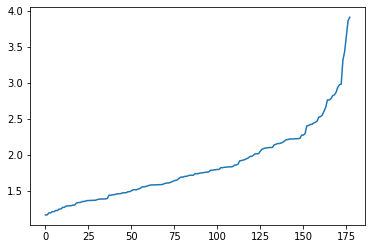

In [15]:
from sklearn.neighbors import NearestNeighbors

min_samples = 2 * len(X_scaled.columns)

neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Use the cluster algorithm on dataset without missing values shows, that DBSCAN is not performaing well with 13 dimensional dataset (empty space problem leads to either 1 or 0 clusters).

In [16]:
# run DBSCAN on original data
config["DBSCAN"]["eps"] = 2
config["DBSCAN"]["min_samples"] = min_samples
if save_output or save_models:
    with open(config_path, "w") as f:
        toml.dump(config, f)

dbscan_orig = DBSCAN(**config["DBSCAN"]).fit(X_scaled)
labels_orig = dbscan_orig.labels_
print(f"DBSCAN noise: {(sum(abs(labels_orig[labels_orig == -1]))*100) / len(labels_true)}%")

DBSCAN noise: 100.0%


#### 1.3.2 K-Means
As an alternative, we use k-means for the initial clustering (k=3). This does clearly work better with a more than 96% correct labeling of data.

In [17]:
from sklearn.cluster import KMeans
k_mean_orig = KMeans(n_clusters=3, random_state=seed_value).fit(X_scaled)
labels_orig = k_mean_orig.labels_

Using munkres/hungarian algorithm to allign the k-means cluster names with the original cluster means.\
Source: https://gist.github.com/siolag161/dc6e42b64e1bde1f263b

In [18]:
from munkres import Munkres
from sklearn.metrics import confusion_matrix

# use Munkres / Hungarian algorithm to relabel clusters in order to match original label names
def make_cost_matrix(c1, c2):
    """
    """
    uc1 = np.unique(c1)
    uc2 = np.unique(c2)
    l1 = uc1.size
    l2 = uc2.size
    assert(l1 == l2 and np.all(uc1 == uc2))

    m = np.ones([l1, l2])
    for i in range(l1):
        it_i = np.nonzero(c1 == uc1[i])[0]
        for j in range(l2):
            it_j = np.nonzero(c2 == uc2[j])[0]
            m_ij = np.intersect1d(it_j, it_i)
            m[i,j] =  -m_ij.size
    return m

In [19]:
cost_matrix = make_cost_matrix(labels_orig, labels_true)
indexes = Munkres().compute(cost_matrix)
mapping = [new for (_, new) in indexes]
labels_orig_renamed = np.choose(labels_orig, mapping).astype(np.int64)

mislabeled = labels_true - labels_orig_renamed
mislabeled[mislabeled != 0] = 1
mislabeled_orig = sum(mislabeled) / len(mislabeled)
print(f"{round(mislabeled_orig * 100, 2)}% mislabeled")

3.37% mislabeled


Get cluster means for loss function input.

In [20]:
# get cluster means (used to calculate the cluster mean loss)
complete_data = X.copy()
complete_data["C"] = labels_orig
cluster_means = complete_data.groupby("C").agg("mean")
cluster_means = cluster_means if -1 not in cluster_means.index else cluster_means.drop(-1)

## 2. Filling Strategies


### 2.1. Define custom-loss
The loss function for the model fitting shall be customized to improve cluster perforamnce. The custom loss is divided into 2 separate losses

1. **Reconstruction Loss**\
Classic loss function, such as RMSE.
2. **Cluster-Mean Loss**\
The distance to the nearest cluster mean shall be minimized.
3. **KL Divergence Loss**\
Deviation of original distribution shall be minimized \
(prob distribution based on https://stackoverflow.com/questions/57687458/how-to-calculate-probabilities-using-numpy-histogram-and-then-use-it-for-calcula \
number of bins: D. Freedman & P. Diaconis (1981) “On the histogram as a density estimator: L2 theory”. Probability Theory and Related Fields 57 (4): 453-476)

The chosen approach to implement the cluster-mean loss is as follows:\
**Adapt the loss function** to calculate a distance to each cluster. The minimum distance (to the nearest cluster) will be used as a cluster-mean-loss. Minimizing this loss should result in the data point moving closer to the nearest cluster mean.\
Potential Problem: loss functions currently work with y_true (true values) and y_score (predicted values). Calculating the distance would require all features. Calculating only the 1 dimensional distance will result in missing values being put into wrong clusters - depending on the first estimate.

In [21]:
# define custom loss function: extend L2-loss by cluster-mean-loss

from pytorch_tabnet.metrics import Metric
from sklearn.metrics import mean_squared_error

class custom_loss(Metric):

    def __init__(self):
        self._name = "custom_loss"
        self._maximize = False

    def __call__(self, y_true, y_score, cluster_means, y_name, x_val, y_val, cl_weights = [0.5, 1, 0.0001]):
        # reconstruction loss
        rmse = np.sqrt(mean_squared_error(y_true, y_score))
        
        # cluster mean loss
        cml = 0 if cl_weights[2] == 0 else self.cluster_mean_loss(cluster_means, y_score, y_name, x_val, y_val)
        
        # KL divergence loss
        bins = len(astropy.stats.freedman_bin_width(y_true.reshape(1,-1)[0], return_bins=True)[1])
        distr1, distr2 = self.probability_dist(y_score, y_true, bins)
        KLdl = torch.nn.functional.kl_div(torch.tensor(distr1).log(), torch.tensor(distr2), log_target=False, reduction='sum').item()
        
        # total loss
        custom_loss = cl_weights[0] * rmse + cl_weights[1] * KLdl + cl_weights[2] * cml
        return custom_loss
    
    # calculate sum of distances to the closest cluster mean
    def cluster_mean_loss(self, cluster_means, y_score, y_name, x_val, y_val):
        
        # reorder cluster_means to match x_val columns (predicted feature is last column)
        cols = cluster_means.columns.tolist()
        feature_col = X.columns.get_loc(y_name)
        cols = cols[:feature_col] + cols[feature_col+1:] + [y_name]
        
        # x values extended by predicted values
        x_extended = pd.DataFrame(np.hstack((x_val, y_score)), columns=cols)


        # calculate distances to each cluster and select the closest one
        dist = []
        for cluster in range(cluster_means.shape[0]):
            dist.append(np.linalg.norm((x_extended - cluster_means.iloc[cluster]), axis=1))
            
        dist = pd.DataFrame(dist).T
        min_dist = dist.assign(min_dist=lambda d: d.min(1))["min_dist"]
        
        return sum(min_dist)
    
    # calculate probabilities
    def probability_dist(self, x, y, bins):
        # transforms 2 series into their probability distributions
        # histogram
        hist_xy = np.histogram2d(np.asarray(x)[:,0], np.asarray(y)[:,0], bins=bins)[0]

        # compute marginals
        hist_xy = hist_xy + sys.float_info.min # prevent division with 0
        hist_xy = hist_xy / np.sum(hist_xy)
        hist_x = np.sum(hist_xy, axis=1)
        hist_y = np.sum(hist_xy, axis=0)
        return(hist_x, hist_y)

### 2.2. Fill missing values (TabNet)

**Approach 1:**\
For each feature that contains missing values, use all rows with complete other features as train set and predict missing values of the feature.\
&rarr; Problem: lots of models, especially for high-dimensional datasets. 
Also problem, if more than one feature is missing values. &rarr; see Approach 2

**Approach 2:**\
Mask missing values as -1 (or some other value) and fit a model predicting each feature just like in approach 1.\
This way the amount of required models can be reduced and the model can learn correlations from the presence of missing values. However we cannot expect an improvement from learning correlations when the missing data is MCAR, as "missing values (MCAR) are interpreted as a random reduction of the dataset, which provide no further information for assigning incomplete feature
vectors to clusters." (H. Timm, et al., "Different approaches to fuzzy clustering of incomplete datasets")\
&rarr; one model for each feature containing missing values.\
Possible adaption: use predicted values to predict subsequent values (instead of using -1)

In [22]:
import time

from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split

X_reconstr = {}
X_reconstr["TabNet"] = {}
output["costs"] = {}
output["runtimes"] = {}
output["predictions"] = {}

for run in range(config["general"]["runs"]):
    
    print(f"Run {run + 1} / {config['general']['runs']}")
    X_reconstr["TabNet"][run] = []
    output["costs"][f"run_{run}"] = {}
    output["runtimes"][f"run_{run}"] = {}
    output["predictions"][f"run_{run}"] = {}
                            
    for i, experiment_value in enumerate(experiment_variable_values):
        
        # get varying learning rates from config
        regressor_param["optimizer_params"] = {"lr":config["regressor_param"]["optimizer_params"][i]}
        config["model_param"]["patience"] = patience_values[i]
        config["model_param"]["max_epochs"] = epochs_values[i]
         
        time_start = time.time()
        X_reconstr["TabNet"][run].append(X_mv.copy())
        output["costs"][f"run_{run}"][str(experiment_value)] = {}
        output["runtimes"][f"run_{run}"][str(experiment_value)] = {}
        output["predictions"][f"run_{run}"][str(experiment_value)] = {}
        
        for feature in features_to_predict:
            
            
            # select % of features for prediction based on pred_features (e.g. 10% of randomly selected features)
            n_features = math.ceil(config["RQ2"]["pred_features"] * (len(X_mv.columns)) - 1)
            X_mv_masked = X_mv.copy().drop(feature, axis=1).sample(n=n_features, axis='columns')
            other_features = X_mv_masked.columns

            # mask other columns' missing values as defined in config (missing_value_mask)
            X_mv_masked[feature] = X_mv[feature]
            X_mv_masked[other_features] = X_mv_masked[(other_features)].fillna(config["general"]["missing_value_mask"])

            # separate complete rows as train data
            # separate column with missing values as target
            test_data = X_mv_masked[X_mv_masked[feature].isna()].drop(feature, axis=1).to_numpy()
            train_data = X_mv_masked[X_mv_masked[feature].notna()]
            train_features = train_data.drop(columns=feature).to_numpy()
            train_target = train_data[feature].to_numpy().reshape(-1,1)

            x_train, x_val, y_train, y_val = train_test_split(train_features, train_target, train_size=config["training"]["train_val_split"])

            # create & train model
            model = TabNetRegressor(**regressor_param)
            if config["model_param"]["eval_metric"] == ["custom_loss"]:
                model.fit(
                    x_train, y_train,
                    eval_set=[(x_val, y_val)],
                    **config["model_param"],
                    cluster_means=cluster_means,
                    y_name=feature,
                    x_val=x_val,
                    y_val=y_val,
                    cl_weights=config["training"]["cl_weights"]
                )
            else:
                model.fit(
                    x_train, y_train,
                    eval_set=[(x_val, y_val)],
                    **config["model_param"]
                )     
            
            # save costs
            output["costs"][f"run_{run}"][str(experiment_value)][feature] = model.best_cost

            # save predictions
            predictions = [x[0] for x in model.predict(test_data)]
            output["predictions"][f"run_{run}"][str(experiment_value)][feature] = predictions
            
            # fill missing values with model predictions
            X_reconstr["TabNet"][run][i].loc[X_reconstr["TabNet"][run][i][feature].isna(), feature] = predictions

            # save outputs
            if save_models:

                # save model
                torch.save(model, os.path.join(models_path, f"Model_run{run}_{config['general']['experiment_variable']}{experiment_value}_{feature}.pt"))            
            
            #track runtime
            time_end = time.time()

            if save_output:
                # save runtimes
                output["runtimes"][f"run_{run}"][str(experiment_value)][feature] = time_end - time_start


Run 1 / 100

Early stopping occurred at epoch 244 with best_epoch = 94 and best_val_0_custom_loss = 14.7824
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 210 with best_epoch = 85 and best_val_0_custom_loss = 4.48369
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 300 with best_epoch = 249 and best_val_0_custom_loss = 3.83431
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 190 with best_epoch = 115 and best_val_0_custom_loss = 5.24234
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 120 with best_epoch = 70 and best_val_0_custom_loss = 5.99353
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 133 with best_epoch = 83 and best_val_0_custom_loss = 3.20137
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 82 and bes


Early stopping occurred at epoch 150 with best_epoch = 100 and best_val_0_custom_loss = 4.55653
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 144 and best_val_0_custom_loss = 3.43781
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 80 and best_val_0_custom_loss = 3.61988
Best weights from best epoch are automatically used!
Run 9 / 100

Early stopping occurred at epoch 298 with best_epoch = 148 and best_val_0_custom_loss = 12.08649
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 400 with best_epoch = 329 and best_val_0_custom_loss = 4.4799
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 141 with best_epoch = 41 and best_val_0_custom_loss = 3.70621
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 80 with best_epoc

Stop training because you reached max_epochs = 400 with best_epoch = 339 and best_val_0_custom_loss = 3.45375
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 272 with best_epoch = 172 and best_val_0_custom_loss = 4.45269
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 166 with best_epoch = 91 and best_val_0_custom_loss = 4.53698
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 31 and best_val_0_custom_loss = 10.18868
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 128 and best_val_0_custom_loss = 3.00002
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 84 and best_val_0_custom_loss = 6.16799
Best weights from best epoch are automatically used!
Run 17 / 100
Stop training because you reached max_epochs = 500 


Early stopping occurred at epoch 50 with best_epoch = 0 and best_val_0_custom_loss = 88.72564
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 97 and best_val_0_custom_loss = 85.77863
Best weights from best epoch are automatically used!
Run 24 / 100

Early stopping occurred at epoch 368 with best_epoch = 218 and best_val_0_custom_loss = 10.97714
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 244 with best_epoch = 119 and best_val_0_custom_loss = 4.77385
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 300 with best_epoch = 296 and best_val_0_custom_loss = 2.85757
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 187 with best_epoch = 112 and best_val_0_custom_loss = 3.57271
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 158 with best_epoch = 108 an


Early stopping occurred at epoch 189 with best_epoch = 89 and best_val_0_custom_loss = 4.73407
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 205 and best_val_0_custom_loss = 6.98788
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 111 with best_epoch = 61 and best_val_0_custom_loss = 9.78294
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 147 and best_val_0_custom_loss = 4.24241
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 96 and best_val_0_custom_loss = 3.85072
Best weights from best epoch are automatically used!
Run 32 / 100

Early stopping occurred at epoch 266 with best_epoch = 116 and best_val_0_custom_loss = 15.51278
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 400

Stop training because you reached max_epochs = 100 with best_epoch = 79 and best_val_0_custom_loss = 4.17204
Best weights from best epoch are automatically used!
Run 39 / 100
Stop training because you reached max_epochs = 500 with best_epoch = 377 and best_val_0_custom_loss = 11.67771
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 400 with best_epoch = 322 and best_val_0_custom_loss = 4.23853
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 134 with best_epoch = 34 and best_val_0_custom_loss = 7.01333
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_custom_loss = 3.74406
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 185 and best_val_0_custom_loss = 4.29607
Best weights from best epoch are automatically used!
Stop training because y


Early stopping occurred at epoch 130 with best_epoch = 30 and best_val_0_custom_loss = 38.19905
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 102 with best_epoch = 27 and best_val_0_custom_loss = 5.58208
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 123 with best_epoch = 73 and best_val_0_custom_loss = 5.26647
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 127 with best_epoch = 77 and best_val_0_custom_loss = 3.06688
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 72 and best_val_0_custom_loss = 7.31472
Best weights from best epoch are automatically used!
Run 47 / 100
Stop training because you reached max_epochs = 500 with best_epoch = 498 and best_val_0_custom_loss = 9.48166
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 286 with best_epoch = 161 and b


Early stopping occurred at epoch 86 with best_epoch = 36 and best_val_0_custom_loss = 11.82005
Best weights from best epoch are automatically used!
Run 54 / 100
Stop training because you reached max_epochs = 500 with best_epoch = 481 and best_val_0_custom_loss = 7.90405
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 147 with best_epoch = 22 and best_val_0_custom_loss = 9.48392
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 300 with best_epoch = 205 and best_val_0_custom_loss = 3.29697
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 152 with best_epoch = 77 and best_val_0_custom_loss = 2.75334
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 118 with best_epoch = 68 and best_val_0_custom_loss = 3.35964
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 136 with best_epoch = 86 and be


Early stopping occurred at epoch 113 with best_epoch = 38 and best_val_0_custom_loss = 3.28675
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 198 and best_val_0_custom_loss = 4.63232
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 102 and best_val_0_custom_loss = 4.53509
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_val_0_custom_loss = 3.98192
Best weights from best epoch are automatically used!
Run 62 / 100

Early stopping occurred at epoch 158 with best_epoch = 8 and best_val_0_custom_loss = 18.91277
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 150 with best_epoch = 25 and best_val_0_custom_loss = 6.29485
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 130 with best_epoc


Early stopping occurred at epoch 209 with best_epoch = 59 and best_val_0_custom_loss = 15.17511
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 350 with best_epoch = 225 and best_val_0_custom_loss = 4.14868
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 300 with best_epoch = 296 and best_val_0_custom_loss = 3.44179
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 235 and best_val_0_custom_loss = 4.31444
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 0 and best_val_0_custom_loss = 11.48183
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 132 and best_val_0_custom_loss = 2.74207
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_ep


Early stopping occurred at epoch 86 with best_epoch = 11 and best_val_0_custom_loss = 4.52883
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 97 with best_epoch = 47 and best_val_0_custom_loss = 4.31545
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 120 with best_epoch = 70 and best_val_0_custom_loss = 4.34284
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 94 and best_val_0_custom_loss = 7.52178
Best weights from best epoch are automatically used!
Run 77 / 100

Early stopping occurred at epoch 178 with best_epoch = 28 and best_val_0_custom_loss = 15.89158
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 203 with best_epoch = 78 and best_val_0_custom_loss = 6.1845
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 300 with best_epoch = 212 and best_

Stop training because you reached max_epochs = 500 with best_epoch = 499 and best_val_0_custom_loss = 10.37975
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 369 with best_epoch = 244 and best_val_0_custom_loss = 4.75652
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 134 with best_epoch = 34 and best_val_0_custom_loss = 5.6312
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 112 with best_epoch = 37 and best_val_0_custom_loss = 3.98791
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 80 with best_epoch = 30 and best_val_0_custom_loss = 7.87093
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 108 with best_epoch = 58 and best_val_0_custom_loss = 5.50331
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 96 and best_val_0_custo


Early stopping occurred at epoch 114 with best_epoch = 64 and best_val_0_custom_loss = 17.76303
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 82 with best_epoch = 32 and best_val_0_custom_loss = 10.9574
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 58 and best_val_0_custom_loss = 4.20463
Best weights from best epoch are automatically used!
Run 92 / 100
Stop training because you reached max_epochs = 500 with best_epoch = 499 and best_val_0_custom_loss = 8.60296
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 400 with best_epoch = 398 and best_val_0_custom_loss = 3.86527
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 134 with best_epoch = 34 and best_val_0_custom_loss = 6.89432
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 139 with best_epoc


Early stopping occurred at epoch 223 with best_epoch = 98 and best_val_0_custom_loss = 4.38607
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 300 with best_epoch = 297 and best_val_0_custom_loss = 3.39602
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 164 with best_epoch = 89 and best_val_0_custom_loss = 4.4434
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 200 with best_epoch = 185 and best_val_0_custom_loss = 4.1738
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 150 with best_epoch = 125 and best_val_0_custom_loss = 3.47591
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 100 with best_epoch = 97 and best_val_0_custom_loss = 4.58864
Best weights from best epoch are automatically used!
Run 100 / 100
Stop training because you reached max_e

### 2.2. Fill missing values (Heuristic Imputation)
Replacing missing values by a heuristic (such as the mean) of their respective feature.

In [23]:
from sklearn.impute import SimpleImputer

mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean').fit(X_mv)
median_imputer = SimpleImputer(missing_values=np.nan, strategy='median').fit(X_mv)

X_reconstr["Heuristic"] = {}
X_reconstr["Heuristic"]["mean"] = pd.DataFrame(mean_imputer.transform(X_mv), columns=wine['feature_names'])
X_reconstr["Heuristic"]["median"] = pd.DataFrame(median_imputer.transform(X_mv), columns=wine['feature_names'])

### 2.3. Fill missing values (Multivariate Imputation)

In [24]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

multiv_imputer = IterativeImputer(max_iter=10, random_state=seed_value)
multiv_imputer.fit(X_mv)
X_reconstr["Multivariate"] = pd.DataFrame(multiv_imputer.transform(X_mv), columns=wine['feature_names'])

## 3. Reconstruct Dataset
choose best TabNet model based on min. squared custom loss.

In [25]:
best_per_run = []
best_per_run_index = []
for run in range(config["general"]["runs"]):
    cost_list = list(output["costs"][f"run_{run}"].values())
    cost_totals = [sum(c**2 for c in list(x.values())) for x in cost_list]
    best_per_run.append(min(cost_totals))
    best_per_run_index.append(cost_totals.index(min(cost_totals)))
    
best_run = best_per_run.index(min(best_per_run))
best_model = best_per_run_index[best_run]
print(f"Best model: run {best_run} model {best_model}")

X_best = X_reconstr["TabNet"][best_run][best_model]

Best model: run 88 model 4


## 4. Clustering
Apply k-means (k=3) on reconstructed data. In order to make the clusters comparable, the k-Means labels will be replaced using Munkres / Hungarian algorithm as explained here:\
https://gist.github.com/siolag161/dc6e42b64e1bde1f263b \
https://github.com/benchaplin/hungarian-algorithm

In [26]:
# apply clustering
labels_reconstr = []
for run in range(config["general"]["runs"]):
    labels_reconstr.append([])
    for i, var in enumerate(experiment_variable_values):
        
        X_reconstr_scaled = pd.DataFrame(StandardScaler().fit_transform(X_reconstr["TabNet"][run][i]))
        k_mean_reconstr = KMeans(n_clusters=3).fit(X_reconstr_scaled)
        
        cost_matrix = make_cost_matrix(k_mean_reconstr.labels_, labels_true)
        indexes = Munkres().compute(cost_matrix)
        mapping = [new for (_, new) in indexes]
        
        labels_reconstr[run].append(np.choose(k_mean_reconstr.labels_,mapping).astype(np.int64))

## 5. Cluster Performance
Performance metrics to measure distribution preservance and cluster performance
### 5.1 Feature Distributions
Quality / Performance of distribution preservance
#### 5.1.1 Distr. Plot based on best model's predictions

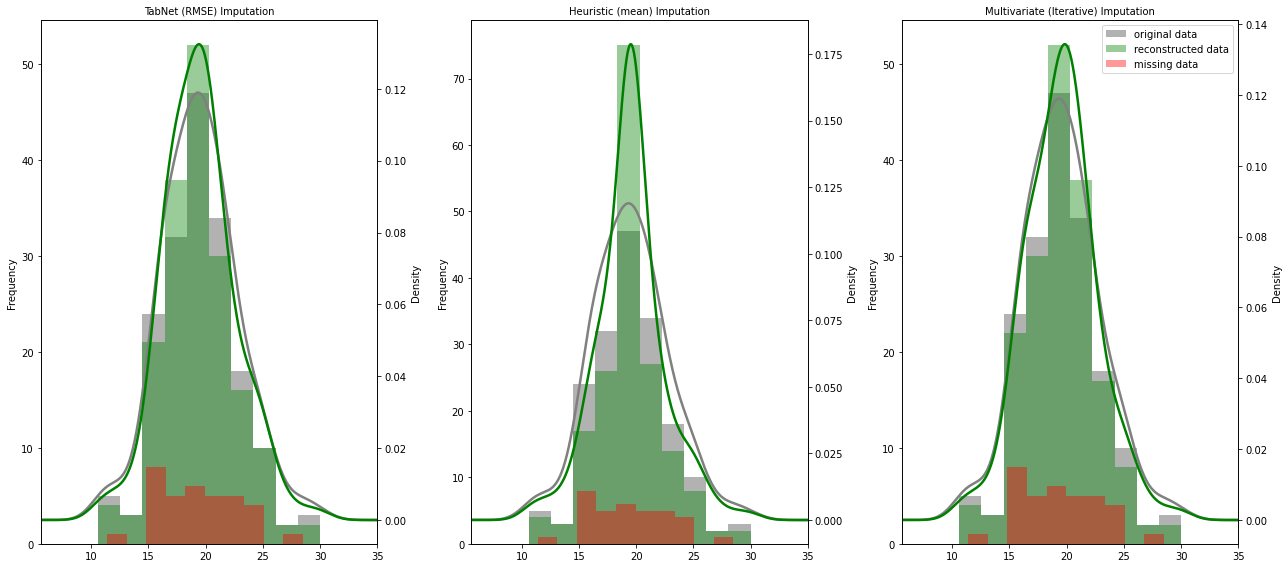

In [27]:
fontsize = 10
fig, axs = plt.subplots(1,3, figsize=(18,8))

x_max = X[experiment_feature].max() + 5
x_min = X[experiment_feature].min() - 5

X[experiment_feature].plot.hist(ax=axs[0], alpha=0.6, color='gray')
X_best[experiment_feature].plot.hist(ax=axs[0], alpha=0.4, color='green')
mv[experiment_feature].plot.hist(ax=axs[0], alpha=0.4, color='red')
axs[0].set_title("TabNet (RMSE) Imputation", fontsize=fontsize)

X[experiment_feature].plot.hist(ax=axs[1], alpha=0.6, color='gray')
X_reconstr["Heuristic"]["mean"][experiment_feature].plot.hist(ax=axs[1], alpha=0.4, color='green')
mv[experiment_feature].plot.hist(ax=axs[1], alpha=0.4, color='red')
axs[1].set_title("Heuristic (mean) Imputation",fontsize=fontsize)

X[experiment_feature].plot.hist(ax=axs[2], alpha=0.6, color='gray')
X_reconstr["Multivariate"][experiment_feature].plot.hist(ax=axs[2], alpha=0.4, color='green')
mv[experiment_feature].plot.hist(ax=axs[2], alpha=0.4, color='red')
axs[2].set_title("Multivariate (Iterative) Imputation",fontsize=fontsize)
plt.legend(['original data', 'reconstructed data', 'missing data'],fontsize=fontsize)

ax2 = axs[0].twinx()
X[experiment_feature].plot.kde(ax=ax2, color='gray', linewidth=2.5)
X_best[experiment_feature].plot.kde(ax=ax2, color='green', linewidth=2.5)
ax2.set_xlim([x_min, x_max])
#mv[experiment_feature].plot.kde(ax=ax2, color='red')

ax2 = axs[1].twinx()
X[experiment_feature].plot.kde(ax=ax2, color='gray', linewidth=2.5)
X_reconstr["Heuristic"]["mean"][experiment_feature].plot.kde(ax=ax2, color='green', linewidth=2.5)
ax2.set_xlim([x_min, x_max])

ax2 = axs[2].twinx()
X[experiment_feature].plot.kde(ax=ax2, color='gray', linewidth=2.5)
X_reconstr["Multivariate"][experiment_feature].plot.kde(ax=ax2, color='green', linewidth=2.5)
ax2.set_xlim([x_min, x_max])

if save_output:
    plt.savefig(os.path.join(plots_path, "5_distributions.png"), **config["plots"])
    
plt.tight_layout()  
plt.show()

#### 5.1.2 Number / share of outliers

In [28]:
output["n_outliers"]["X_reconstr"] = {}

for run in range(config["general"]["runs"]):
    output["n_outliers"]["X_reconstr"][f"run_{run}"] = {}
    for i, experiment_value in enumerate(experiment_variable_values):
        output["n_outliers"]["X_reconstr"][f"run_{run}"][str(experiment_value)] = {}
        for feature in features_to_predict:
            output["n_outliers"]["X_reconstr"][f"run_{run}"][str(experiment_value)][feature] =  n_outliers(X_reconstr["TabNet"][run][i][feature], config["outlier_definition"]["quantiles"])

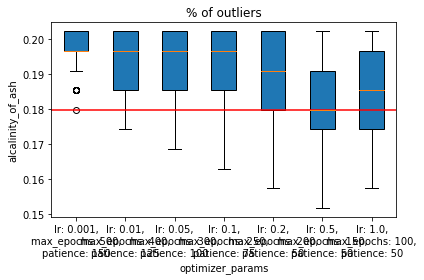

In [29]:
# share of outliers
data = {}
for feature in features_to_predict:
    data[feature] = {}
    for i, experiment_value in enumerate(experiment_variable_values):
        data[feature][f"lr: {str(experiment_value)},\nmax_epochs: {epochs_values[i]},\npatience: {patience_values[i]}"] = [x[str(experiment_value)][feature]/len(X) for x in output["n_outliers"]["X_reconstr"].values()]

nr_features = len(features_to_predict)

if nr_features == 1:
    fig, ax = plt.subplots()
    ax.boxplot(data[feature].values(), patch_artist = True)
    ax.set_xticklabels(data[feature].keys())
    plt.xlabel(config["general"]["experiment_variable"])
    plt.ylabel(feature)
    plt.axhline(y=output['n_outliers']['X'][feature]/len(X), color='r', linestyle='-')
    plt.title("% of outliers")

if nr_features > 1:
    fig, axs = plt.subplots(nr_features, figsize=(len(experiment_variable_values)*3,nr_features*4))
    fig.suptitle("% of outliers", fontweight='bold')

    for nr, feature in enumerate(features_to_predict):
        axs[nr].boxplot(data[feature].values(), patch_artist = True) # , showfliers=False
        axs[nr].set_xticklabels(data[feature].keys())
        axs[nr].set_xlabel(config["general"]["experiment_variable"])
        axs[nr].set_ylabel(feature, fontweight='bold')

plt.tight_layout() 

if save_output:
    plt.savefig(os.path.join(plots_path, "5_outliers.png"), **config["plots"])
    
plt.show()

#### 5.1.2 KL Divergence
using freedman algorithm to determine bin widths of the probability distribution

In [30]:
# KL Divergence
def kl_divergence(feature1, feature2):
    
    # calculate probability distributions
    def probability_dist(x, y, bins):
        # transforms 2 series into their probability distributions
        # histogram
        hist_xy = np.histogram2d(x, y, bins=bins)[0]

        # compute marginals
        hist_xy = hist_xy + sys.float_info.min # prevent division with 0
        hist_xy = hist_xy / np.sum(hist_xy)
        hist_x = np.sum(hist_xy, axis=1)
        hist_y = np.sum(hist_xy, axis=0)
        return(hist_x, hist_y)

    # calculate kl divergence
    bins = len(astropy.stats.freedman_bin_width(feature1, return_bins=True)[1])
    distr1, distr2 = probability_dist(feature1, feature2, bins)
    return torch.nn.functional.kl_div(torch.tensor(distr1).log(), torch.tensor(distr2), log_target=False, reduction='sum').item()

In [31]:
output["kl_divergence"] = {}

# save kl divergence
for run in range(config["general"]["runs"]):
    output["kl_divergence"][f"run_{run}"] = {}
    for i, experiment_value in enumerate(experiment_variable_values):
        output["kl_divergence"][f"run_{run}"][str(experiment_value)] = {}
        for feature in features_to_predict:
            output["kl_divergence"][f"run_{run}"][str(experiment_value)][feature] = kl_divergence(X[feature], X_reconstr["TabNet"][run][i][feature])

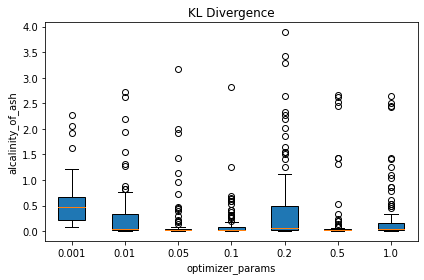

In [32]:
# plot
data = {}
for feature in features_to_predict:
    data[feature] = {}
    for experiment_value in experiment_variable_values:
        data[feature][str(experiment_value)] = [x[str(experiment_value)][feature] for x in output["kl_divergence"].values()]

nr_features = len(features_to_predict)

if nr_features == 1:
    fig, ax = plt.subplots()
    ax.boxplot(data[feature].values(), patch_artist = True)
    ax.set_xticklabels(data[feature].keys())
    plt.xlabel(config["general"]["experiment_variable"])
    plt.ylabel(feature)
    plt.title("KL Divergence")

if nr_features > 1:
    fig, axs = plt.subplots(nr_features, figsize=(len(experiment_variable_values)*3,nr_features*4))
    fig.suptitle(f"KL divergence, {config['general']['runs']} runs", fontweight='bold')

    for nr, feature in enumerate(features_to_predict):
        axs[nr].boxplot(data[feature].values(), patch_artist = True) # , showfliers=False
        axs[nr].set_xticklabels(data[feature].keys())
        axs[nr].set_xlabel(config["general"]["experiment_variable"])
        axs[nr].set_ylabel(feature, fontweight='bold')

plt.tight_layout() 

if save_output:
    plt.savefig(os.path.join(plots_path, "5_kl_divergence.png"), **config["plots"])
    
plt.show()

### 5.2. Cluster Performance
#### 5.2.1. ARI Score

In [33]:
from sklearn.metrics.cluster import adjusted_rand_score

output["ARI_score"] = {}
output["ARI_score"]["orig_data"] = adjusted_rand_score(labels_orig, labels_true)

for run in range(config["general"]["runs"]):
    output["ARI_score"][f"run_{run}"] = {}
    for i, experiment_value in enumerate(experiment_variable_values):
        ari = adjusted_rand_score(labels_reconstr[run][i], labels_true)
        output["ARI_score"][f"run_{run}"][str(experiment_value)] = ari

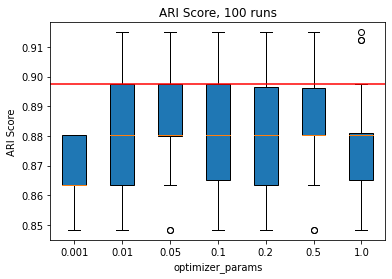

In [34]:
# plot
ari = output["ARI_score"].copy()
del(ari['orig_data'])

data = {}
for experiment_value in experiment_variable_values:
    data[str(experiment_value)] = [x[str(experiment_value)] for x in ari.values()]

fig, ax = plt.subplots()
ax.boxplot(data.values(), patch_artist = True)
ax.set_xticklabels(data.keys())
plt.axhline(y=output['ARI_score']['orig_data'], color='r', linestyle='-')
plt.xlabel(config["general"]["experiment_variable"])
plt.ylabel("ARI Score")
plt.title(f"ARI Score, {config['general']['runs']} runs")

if save_output:
    plt.savefig(os.path.join(plots_path, "5_ARI-score.png"), **config["plots"])

plt.show()

### 5.3. Save Output

In [35]:
if save_output:
    # save output file
    with open(output_path, "w") as f:
                toml.dump(output, f)

    # save notebook
    shutil.copy2(nb_name, experiment_path)

## 6. Old Code

Predictions out of original min/max range

data = {}

for feature in features_to_predict:
    data[feature] = {}
    n_predictions = sum(X_mv[feature].isna()) * config["general"]["runs"]
    min_val = X[feature].min()
    max_val = X[feature].max()
    n_inliers = 0
    
    for experiment_value in experiment_variable_values:
        data[feature][str(experiment_value)] = 0  
        
        for run in range(config["general"]["runs"]):
            data[feature][str(experiment_value)] += sum([True if x > min_val and x < max_val else False for x in output["predictions"][f"run_{run}"][str(experiment_value)][feature]])
    
        data[feature][str(experiment_value)] = data[feature][str(experiment_value)] / n_predictions

n_features = len(features_to_predict) if len(features_to_predict) > 1 else 2
base_height = 5
base_width = 2
fontsize=10

fig, axs = plt.subplots(n_features, figsize=(len(experiment_variable_values)*base_width,n_features*base_height))
fig.suptitle(f"% of predicted values within original range", fontweight='bold',fontsize=fontsize)

for nr, feature in enumerate(features_to_predict):
    axs[nr].plot(data[feature].keys(), data[feature].values())
    axs[nr].set_xlabel(config["general"]["experiment_variable"],fontsize=fontsize)
    axs[nr].set_ylabel(feature, fontweight='bold', fontsize=fontsize)
    axs[nr].set_ylim([0, 1])
    axs[nr].text(0.9, 0.9, f"{[x for x in config['general']['missing_percent'] if x != 0][nr]}% missing", horizontalalignment='center', verticalalignment='center', transform=axs[nr].transAxes, fontsize=30)

plt.tight_layout() 

if save_output:
    plt.savefig(os.path.join(plots_path, "5_prediction_range_rel.png"), **config["plots"])

plt.show()

data = {}
for feature in features_to_predict:
    data[feature] = {}
    for i, experiment_value in enumerate(experiment_variable_values):
        # add all replaced values from all runs to a list
        data[feature][str(experiment_value)] = []
        for run in range(config["general"]["runs"]): 
            data[feature][str(experiment_value)].extend(output["predictions"][f"run_{run}"][str(experiment_value)][feature])

nr_features = len(features_to_predict) if len(features_to_predict) > 1 else 2
base_height = 5
base_width = 3
fontsize=10

fig, axs = plt.subplots(nr_features, figsize=(len(experiment_variable_values)*base_width,nr_features*base_height))
fig.suptitle(f"Predicted values", fontweight='bold',fontsize=fontsize)

for nr, feature in enumerate(features_to_predict):
    axs[nr].boxplot(data[feature].values(), patch_artist = True)
    axs[nr].set_xticklabels(data[feature].keys(),fontsize=fontsize)
    axs[nr].set_xlabel(config["general"]["experiment_variable"],fontsize=fontsize)
    axs[nr].set_ylabel(feature, fontweight='bold', fontsize=fontsize)
    axs[nr].axhline(X[feature].min(),color='red',ls='-')
    axs[nr].axhline(X[feature].max(),color='red',ls='-')
    axs[nr].text(0.9, 0.9, f"min {X[feature].min()}\nmax {X[feature].max()}", horizontalalignment='center', verticalalignment='center', transform=axs[nr].transAxes, fontsize=fontsize*1.5)

plt.tight_layout() 

if save_output:
    plt.savefig(os.path.join(plots_path, "5_prediction_range_abs.png"), **config["plots"])

plt.show()

Feature distributions

bins = len(astropy.stats.freedman_bin_width(X[feature], return_bins=True)[1])
n_feat = len(features_to_predict) if len(features_to_predict) > 1 else 2

fig, (ax) = plt.subplots(n_feat, 2, figsize=(10,n_feat*3))
fig.suptitle(f"distributions based on best model", fontweight='bold')
for n, feature in enumerate(X_best[features_to_predict]):
    ax[n, 0].hist(X[feature], bins=bins)
    ax[n, 0].set_title(f"{feature}_orig")
    ax[n, 1].hist(X_best[feature], bins=bins)
    ax[n, 1].set_title(f"{feature}_reconstructed")

fig.tight_layout()
plt.show()
if save_output:
    plt.savefig(os.path.join(plots_path, "feature distributions.png"), **config["plots"])